In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
from tqdm.auto import tqdm
from collections import defaultdict
from tensorflow.keras import metrics
from tabulate import tabulate
import matplotlib.pyplot as plt
from multiprocessing import Pool
from random import randint
from typing import Any, Dict, List, Sequence
import time

import numpy.typing as npt
!pip install scaaml
from scaaml.aes import ap_preds_to_key_preds
from scaaml.plot import plot_trace, plot_confusion_matrix
#from scaaml.utils import tf_cap_memory, from_categorical
#from scaaml.model import get_models_by_attack_point, get_models_list, load_model_from_disk
from scaaml.intro.generator import list_shards, load_attack_shard
# scaaml.utils import hex_display, bytelist_to_hex

In [3]:
from typing import Sequence, List
import numpy.typing as npt


def pretty_hex(e: int) -> str:
    """Representation of an integer as a zero-padded two-digit hex string."""
    return f"{e:02X}"


def hex_line(chars: Sequence[int], spacer: str = " ") -> str:
    """Render some chars as hex with a spacer between them"""
    h = []
    for e in chars:
        h.append(pretty_hex(e))
    return spacer.join(h)


def hex_display(lst: Sequence[int],
                prefix: str = "",
                color: str = "green") -> None:
    """Display a list of int as colored hex."""
    h = []
    for e in lst:
        h.append(pretty_hex(e))
    hex_representation = prefix + " ".join(h)
    # Assuming you print with some styled color effect
    print(f"{color}: {hex_representation}")  # Example use of the 'color' parameter

def from_categorical(predictions: Sequence[npt.ArrayLike]) -> List[np.intp]:
    "reverse of categorical"
    # note: doing it as a list is significantly faster than a single argmax
    return [np.argmax(p) for p in predictions]


In [4]:
ATTACK_POINT = 'sub_bytes_in'

# let's also pick the key byte we want to use SCAAML to recover and load the related model
ATTACK_BYTE = 0

In [1]:
import src.DAT255_SCA.utils.dataset_utils as utils
file_path = "C:\\Users\\Kaspar\\ChipWhisperer\\chipwhisperer\\jupyter\\courses\\sca101\\testing_set.hdf5"
utils.close_file(file_path)
utils.create_dataset(file_path, 256,256, "test")

(65536, 16) (65536, 16)
(16, 65536) (16, 65536)
org keys
[123 212  64 231 103 136  38 171 145  68 207 235  35  71 173  84]
[ 57 170 230  85  32 242 235  10  99 189  98  40 225  24  61 217]
[ 47 214  59 232 208  22  62  83 138 221  47  92 206 241  13 118]
transformed keys
[123 212  64 231 103 136  38 171 145  68 207 235  35  71 173  84]
[ 57 170 230  85  32 242 235  10  99 189  98  40 225  24  61 217]
[ 47 214  59 232 208  22  62  83 138 221  47  92 206 241  13 118]
transformed text
[224 219 200 233 245  83  50 242 147 102 179 191 116 239  64 126]
[ 27  48  33 167  55  98  35  37 238 149 205 163 120 116 174 169]
[  7 157 226 123  23 227 230  70  56 225 176  84 246 181  28 112]
text [[224  27   7 ... 177  22 106]
 [219  48 157 ... 123  63  71]
 [200  33 226 ... 255 238 154]
 ...
 [239 116 181 ... 200 112  95]
 [ 64 174  28 ... 192  21  62]
 [126 169 112 ... 131 203  52]]
[[123 123 123 ... 123 123 123]
 [212 212 212 ... 212 212 212]
 [ 64  64  64 ...  64  64  64]
 ...
 [ 71  71  71 ...  7

In [6]:

#importing the models
from tensorflow.keras.models import Model
import tensorflow as tf

model5000 = tf.keras.models.load_model("stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_5000.keras")
#no use for this as our data only has range 5000
#model20000 = tf.keras.models.load_model("stm32f0-tinyaes-cnn-v10-ap_sub_bytes_in-byte_0-len_20000.keras")

In [7]:
import src.DAT255_SCA.utils.dataset_utils as utils
NUM_TRACES = 40  # maximum number of traces to use to recover a given key byte. 10 is already overkill
correct_prediction_rank = defaultdict(list)
y_pred = []
y_true = []
model_metrics = {"acc": metrics.Accuracy()}
file_path = "C:\\Users\\Kaspar\\PycharmProjects\\DAT255_SCA\\notebooks\\('test', 0).hdf5"

#for løkken må endres fordi metoden returnerer en liste av alt
#heller iterere over i, siden første plassen i listen er all info for "shard 1"
arr = np.zeros(256, dtype=int)
x = []
y = []
keys = []
pts = []

x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

for i in tqdm(arr, desc='Recovering bytes', unit='shards'):

    #x = x[i]
    #i den andre er x 40, 5000, 1, her er den bare 5000, 1
    print(x[i].shape)
    # prediction
    predictions = model5000.predict(x[i])

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts[i], ATTACK_POINT)

    c_preds = from_categorical(predictions)
    c_y = from_categorical(y[i])
    # metric tracking
    for metric in model_metrics.values():
        metric.update_state(c_y, c_preds)
    # for the confusion matrix
    y_pred.extend(c_preds)
    y_true.extend(c_y)

    # accumulating probabilities and checking correct guess position.
    # if all goes well it will be at position 0 (highest probability)
    # see below on how to use for the real attack

    #tror denne også må være i
    key = keys[i][0] # all the same in the same shard - not used in real attack
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)
        guess_ranks = (np.argsort(vals, )[-256:][::-1])
        byte_rank = list(guess_ranks).index(key)
        correct_prediction_rank[trace_count].append(byte_rank)
    #maxed out ram before i added this, not sure of the actual effect or if it was random
    del predictions, key_preds, c_preds, c_y

done


Recovering bytes:   0%|          | 0/256 [00:00<?, ?shards/s]

(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 2s/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step 
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step 
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step 
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step 
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
(40, 5000, 1)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
(40, 5000

In [15]:
print("Accuracy: %.2f" % model_metrics['acc'].result())


Accuracy: 0.03


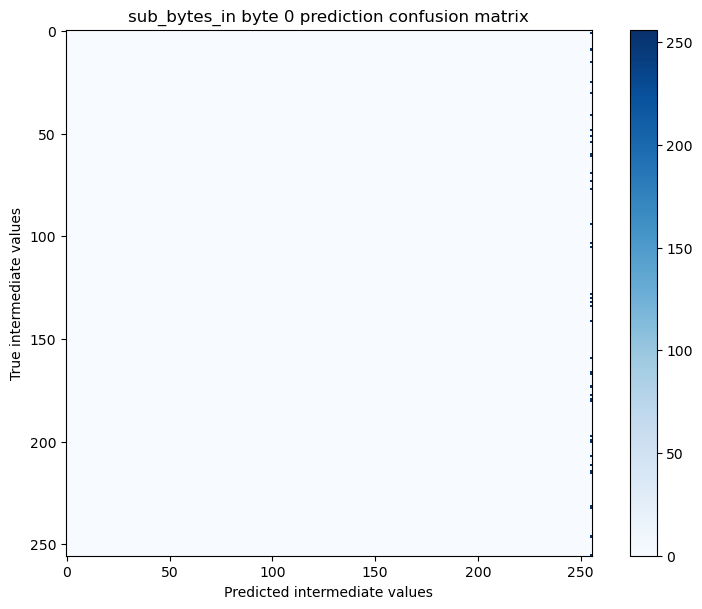

In [16]:
plot_confusion_matrix(y_true, y_pred, normalize=True, title="%s byte %s prediction confusion matrix" % (ATTACK_POINT, ATTACK_BYTE))


In [17]:
config = """{
    "model": "cnn",
    "device": "stm32f415",
    "algorithm": "tinyaes",
    "version": "10",
    "attack_points": [
        "sub_bytes_out",
        "sub_bytes_in",
        "key"
    ],
    "attack_bytes": [
        "0",
        "1",
        "2",
        "3",
        "4",
        "5",
        "6",
        "7",
        "8",
        "9",
        "10",
        "11",
        "12",
        "13",
        "14",
        "15"
    ],
    "max_trace_len": 20000,
    "num_shards": 256,
    "num_traces_per_shard": 256,
    "batch_size": 32,
    "epochs": 30,
    "optimizer_parameters": {
        "lr": 0.001,
        "multi_gpu_lr": 0.001
    },
    "model_parameters": {
        "activation": "relu",
        "initial_filters": 8,
        "initial_pool_size": 4,
        "block_kernel_size": 3,
        "blocks_stack1": 3,
        "blocks_stack2": 4,
        "blocks_stack3": 4,
        "blocks_stack4": 3,
        "dense_dropout": 0.1
    }
}"""
target_config = json.loads(config)


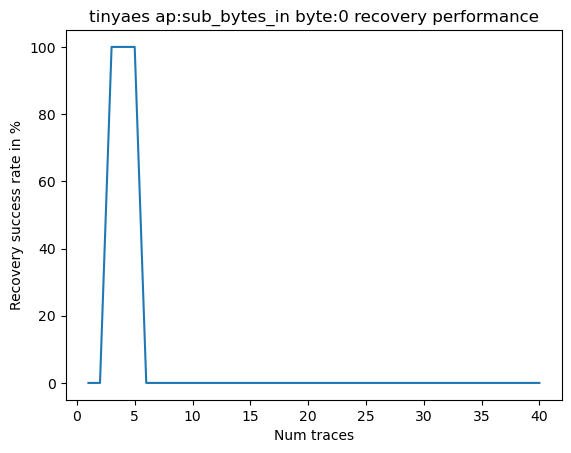

In [18]:
NUM_TRACES_TO_PLOT = 40
avg_preds = np.array([correct_prediction_rank[i].count(0) for i in range(NUM_TRACES_TO_PLOT)])
y = avg_preds / len(correct_prediction_rank[0]) * 100
x = [i + 1 for i in range(NUM_TRACES_TO_PLOT)]
plt.plot(x, y)
plt.xlabel("Num traces")
plt.ylabel("Recovery success rate in %")
plt.title("%s ap:%s byte:%s recovery performance" % (target_config['algorithm'], ATTACK_POINT, ATTACK_BYTE))
plt.show()

In [19]:
min_traces = 0
max_traces = 0
cumulative_aa = 0
for idx, val in enumerate(y):
    cumulative_aa += val
    if not min_traces and val > 0:
        min_traces = idx + 1
    if not max_traces and val == 100.0:
        max_traces = idx + 1
        break

cumulative_aa = round( cumulative_aa / (idx + 1), 2) # divide by the number of steps

rows = [
    ["min traces", min_traces, round(y[min_traces -1 ], 1)],
    ["max traces", max_traces, round(y[max_traces - 1], 1)],
    ["cumulative score", cumulative_aa, '-']
]
print(tabulate(rows, headers=['metric', 'num traces', '% of keys']))

metric              num traces  % of keys
----------------  ------------  -----------
min traces                3     100.0
max traces                3     100.0
cumulative score         33.33  -


In [20]:
ATTACK_POINT = 'sub_bytes_in' # let's pick an attack point- Key is not a good target: it doesn't work for TinyAEs
TARGET_SHARD = 5 # a shard == a different key. Pick the one you would like
NUM_TRACES = 14  # how many traces to use - as seen in single byte, 5 traces is enough

In [14]:
# perfoming 16x the byte recovery algorithm showecased above - one for each key byte
real_key = [] # what we are supposed to find
recovered_key = [] # what we predicted
pb = tqdm(total=16, desc="guessing key", unit='guesses')
for ATTACK_BYTE in range(16):
    # data
    keys, pts, x, y = load_attack_shard(shard_paths[TARGET_SHARD], ATTACK_BYTE, ATTACK_POINT, TRACE_LEN, num_traces=NUM_TRACES, full_key=True)
    real_key.append(keys[0])
    x = x[:,:5000,:]
    # load model
    model = model5000

    # prediction
    predictions = model.predict(x)

    # computing byte prediction from intermediate predictions
    key_preds = ap_preds_to_key_preds(predictions, pts, ATTACK_POINT)

    # accumulating probabity
    vals = np.zeros((256))
    for trace_count, kp in enumerate(key_preds):
        vals = vals  + np.log10(kp + 1e-22)

    # order predictions by probability
    guess_ranks = (np.argsort(vals, )[-256:][::-1])

    # take strongest guess as our key guess
    recovered_key.append(guess_ranks[0])

    # update display
    pb.set_postfix({'Recovered key': bytelist_to_hex(recovered_key), "Real key": bytelist_to_hex(real_key)})
    pb.update()


pb.close()

guessing key:   0%|          | 0/16 [00:00<?, ?guesses/s]

NameError: name 'shard_paths' is not defined

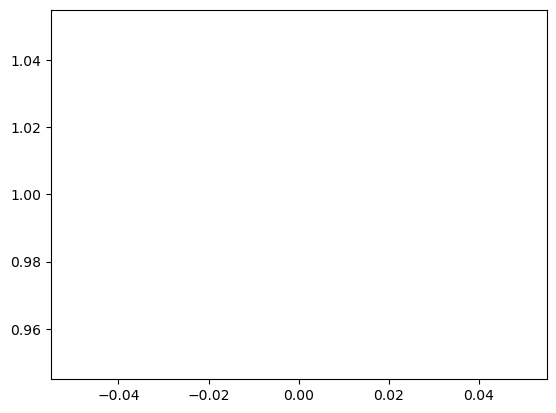

In [109]:
plt.plot(x[0])
plt.show()

AttributeError: 'int' object has no attribute 'shape'

In [2]:
#FEILSØKER METODEN
file_path = "C:\\Users\\Kaspar\\PycharmProjects\\DAT255_SCA\\notebooks\\test_0.hdf5"
ATTACK_BYTE = 0
ATTACK_POINT = "sub_bytes_in"
NUM_TRACES = 20
x, y, keys, pts = utils.load_and_prepare_dataset_for_evaluation(file_path, ATTACK_BYTE, ATTACK_POINT, num_traces=NUM_TRACES)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[ 54 211 255 180 141 128 159  73 166  77 232  48 179  60 200 207  69 130
 105 132]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

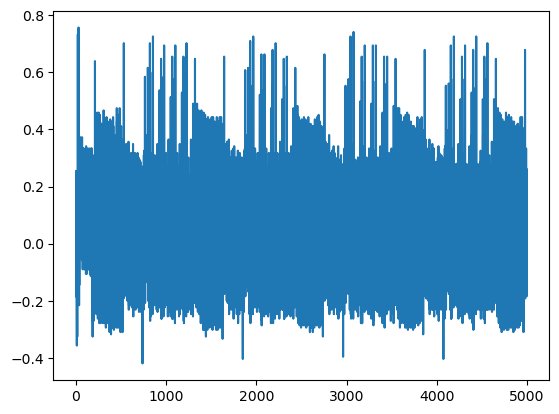

In [7]:
import matplotlib.pyplot as plt
plt.plot(x[0][0]) #ikke skalert?!?!?!

In [8]:
pts[0]

array([ 54, 211, 255, 180, 141, 128, 159,  73, 166,  77, 232,  48, 179,
        60, 200, 207,  69, 130, 105, 132], dtype=uint8)

In [9]:
keys[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [10]:
#noe er feil med nøklene
keys[1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=uint8)

In [3]:
utils.inspect_dataset(file_path)

00578f88f972c4f496b03fa9a5b71a50
1

traces
key
sub_bytes_in
pts
013bd1a40fb9a5db298c40e4b9884220
2

traces
key
sub_bytes_in
pts
024ab28013357b3f5293facf125fef08
3

traces
key
sub_bytes_in
pts
0394eb45fde8141195d6bea59ec240ab
4

traces
key
sub_bytes_in
pts
04a169bcf253271faaf6fd8d698e64d5
5

traces
key
sub_bytes_in
pts
05ac440afc00a78d77f77a15be6cec49
6

traces
key
sub_bytes_in
pts
06b736bb96fbd41af46733d8b4034b6a
7

traces
key
sub_bytes_in
pts
0739d95c68d2c96014f9725bf943655f
8

traces
key
sub_bytes_in
pts
08c95a5d5b6f6815de42894f37916117
9

traces
key
sub_bytes_in
pts
096a2574f58604a2359bb8fef3c84fd1
10

traces
key
sub_bytes_in
pts
0aedb41eba6084d2b7eb64df41f85f05
11

traces
key
sub_bytes_in
pts
0b9288fd84b01f8c64f425374a96c688
12

traces
key
sub_bytes_in
pts
0cbebee5c1e2c0d7e981b2b6ccc7cacb
13

traces
key
sub_bytes_in
pts
0d0419d647ab7ab7e00c37c9c0aa43db
14

traces
key
sub_bytes_in
pts
0e8d1fdc8adcd9862f322ebe59b436bf
15

traces
key
sub_bytes_in
pts
0ffb96d11c8ec8bc4d0f97a873ca7b5e
1